# About
This notebooks is a playground for timeseries forecasting, both using simpler regresson models and using neural networks. I worked on this while taking the [DeepLearning.AI course "Sequences, Time Series and Prediction"](https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction).


## Concepts covered
* Timeseries forecasting, properties of timeseries
* ARIMA models, autoregressive timeseries modeling
* Neural network models 
* Hyperparameter tuning


## Tools used
* Statsmodels: ARIMA
* Tensorfow: `tf.data.Dataset`, `tf.keras.Sequential`

# Imports, setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

import tensorflow as tf

from collections import defaultdict

# Artificial timeseries data
In order to study the concepts and tools rather than the data itself, I'll generate an artificial data which still has characteristic properties of timeseries:
* Trend
* Seasonality
* Non-stationarity
* Autocorrelation

In [2]:
def trend(times, slope=0.001, start=10):
    return (times - times[0])*slope + start

def noise(times, level=0.1, seed=0):
    rng = np.random.RandomState(seed)
    return (rng.rand(*times.shape) - 0.5)*level 

def autocorrelation(signal, lag: int = 1, coeff: float = 0.99):
    correlation = np.concatenate([np.ones(lag)*signal[0], signal[:-lag]])*coeff
    return (signal + correlation)/(1+coeff)

def sin_pattern(fraction, k=1, amplitude=0.1):
    return amplitude*np.sin(k*fraction*np.pi) 

def linear_pattern(fractions, amplitude=0.1):
    linear = fractions
    linear -= np.mean(linear)
    return amplitude*linear

def seasonal(times, period=25, amplitude=0.5, pattern=sin_pattern):
    fractions = (times % period)/period
    return pattern(fractions)*amplitude

def nonstationarity(times, tail_fraction=0.2, slope=-0.005):
    """Add trend to tail of series."""
    x = np.zeros(times.shape)
    tail = int(len(times)*tail_fraction)
    x[-tail:]  = trend(times, slope=slope, start=0)[:tail]
    return x

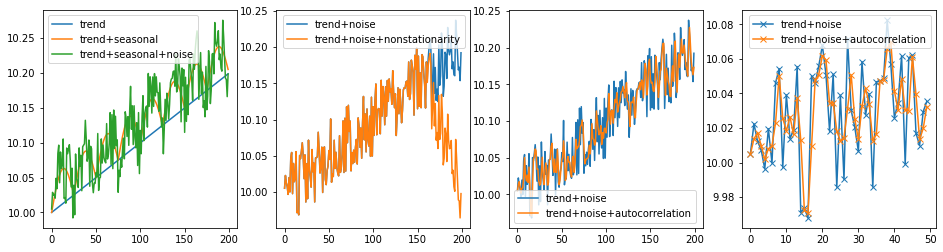

In [3]:
# Data and train, validation split
times = np.arange(200)
split = 100

fig, axes = plt.subplots(1, 4, figsize=(4*4,4))
axes = axes.ravel()

fmt='-'
ax = axes[0]
ax.plot(times, trend(times), fmt, label='trend')
ax.plot(times, trend(times)+seasonal(times), fmt, label='trend+seasonal')
ax.plot(times, trend(times)+seasonal(times)+noise(times), fmt,  label='trend+seasonal+noise')
ax.legend()

ax = axes[1]
ax.plot(times, trend(times)+noise(times), fmt, label='trend+noise')
ax.plot(times, trend(times)+noise(times)+nonstationarity(times), fmt, label='trend+noise+nonstationarity')
ax.legend()

ax = axes[2]
ax.plot(times, trend(times)+noise(times), fmt, label='trend+noise')
ax.plot(times, autocorrelation(trend(times)+noise(times)), fmt, label='trend+noise+autocorrelation')
ax.legend()

s=slice(0,50)
ax = axes[3]
fmt='-x'
ax.plot(times[s], (trend(times)+noise(times))[s], fmt, label='trend+noise')
ax.plot(times[s], autocorrelation(trend(times)+noise(times))[s], fmt, label='trend+noise+autocorrelation')
ax.legend();

# Moving-average regression, ARIMA 
[ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) is a standard model for univariate timeseries prediction. The general form for an ARIMA model of a timeseries $X_t$ is

\begin{equation}
    \left(
    1 - \sum_{i=1}^p \Theta_i^{\text{AR}}L_i
    \right)
    \left(1-L\right)^d
    X_t
    = 
    \delta+
    \left(
    1 + \sum_{i=1}^q \Theta_i^{\text{MA}}L_i 
    \right) \varepsilon_t,
\end{equation}

where 

* $L_i$ is the *lag operator*, $L_i X_t = X_{t-i}$
* $\varepsilon_t$ are *error* terms at time $t$ (typically independent, identically normally distributed, with zero mean)
* $\delta$ is constant *drift* term (modeling a constant trend)

The integer hyperparameters $p, d, q$ determine the number and types of terms included in the model and they to correspond to the [AR](https://en.wikipedia.org/wiki/Autoregressive_model), I, and [MA](https://en.wikipedia.org/wiki/Moving-average_model) part of the ARIMA model, respectively. Thus, a specific ARIMA model can be specified as ARIMA$(p, d, q)$. Here $d$ stands for "difference" as it explicitly includes terms with the difference of  $X_t$ relative to past terms. For instance (assuming $\delta=0$)
* ARIMA(1, 0, 0) model is an 
    [AR(1)](https://en.wikipedia.org/wiki/Autoregressive_model#Example:_An_AR(1)_process) process,
    $X_t = \Theta_1^{\text{AR}} X_{t-1} + \varepsilon_t$
* ARIMA(0, 1, 0), or I(1), is a random walk, $X_t = X_{t-1} + \varepsilon_t$
* ARIMA(0, 0, 1) or MA(1) is a moving average $X_t = \varepsilon_t + \Theta_1^{\text{MA}}\varepsilon_{t-1}$ 

Both the AR and the MA part of the model use past times to model $X_t$ but in different ways. The MA terms incorporate a direct dependency on past error terms  $\varepsilon_{t-i}$, representing a noisy environment. The AR terms on the other hand, model a dependency on the past values of the signal itself. A major difference between the two is that the AR terms will propagate a fluctuation $\varepsilon_t$ to all future times $t'>t$, where the rate of decay is determined by the size of the coefficients $\Theta^{\text{AR}}$, whereas the MA terms will just include it for $q$ future times as a weighted average with weights determined by $\Theta^{\text{MA}}$.

## SARIMA
 *Seasonal ARIMA* (SARIMA) is an extension to ARIMA that incorporates seasonality by adding another "layer" of coefficients for modeling seasonal variations. SARIMA is specificed as ARIMA$(p,d,q)(P,D,Q)S$, where $S$ is the seasonality, e.g. $S=12$ for monthly data and $P, D, Q$ are the orders for the seasonal part of SARIMA. The seasonal terms simply multiply the regular ARIMA polynomial as

\begin{equation}
    \left(
    1 - \sum_{i=1}^p \Theta_i^{\text{AR}}L_i
    \right)
    \left(
    1 - \sum_{i=1}^P \Theta_i^{\text{SAR}}L_{iS}
    \right)
    \left(1-L\right)^d
    \left(1-L_S\right)^D
    X_t
    = 
    \delta+
    \left(
    1 + \sum_{i=1}^q \Theta_i^{\text{MA}}L_i 
    \right)
    \left(
    1 + \sum_{i=1}^Q \Theta_i^{\text{SMA}}L_{iS} 
    \right)
    \varepsilon_t.
\end{equation}

We see that the seasonal lag operators take strides of $S$, meaning  ARIMA$(p,d,q)(1, D, 1)$ will predict $X_t$ using terms $X_{t-S}$ and  ARIMA$(p,d,q)(2, D, 2)$ using also terms $X_{t-2S}$. More examples can be found [here](https://online.stat.psu.edu/stat510/lesson/4/4.1).

## See also
There are additional generalizations to the ARIMA model, see for instance [this summary](https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/).

Here are a couple of tutorials on ARIMA that may be worth looking into:
- [Tutorial on timeseries modeling using ARIMA](https://ucilnica.fri.uni-lj.si/mod/resource/view.php?id=28089)
- [Tutorial on Statsmodel's SARIMAX](https://www.statsmodels.org/dev/examples/index.html#state-space-models)

# ARIMA in `statsmodels`
The ARIMA function from statsmodels supports both standard ARIMA and extensions, including SARIMA.  

Note: I here use the `statsmodels.tsa.arima.model.ARIMA` implementation. There is an alternative (newer) implementation `statsmodels.tsa.statespace.sarimax`.

In [4]:
def mse(y, yhat):
    return np.mean((y - yhat)**2)

def rmse(y, yhat):
    return np.sqrt(mse(y, yhat))

In [5]:
def predict_ARIMA(x, times, model, model_fit):
    "Make predictions for trained model using data x"
    tmp_model = ARIMA(x, order=model.order, trend=model.trend, seasonal_order=model.seasonal_order)
    tmp_fit = tmp_model.smooth(model_fit.params)
    yhat = tmp_fit.predict(times[0], times[-1])
    return yhat

I use artificial data consisting of trend+noise to get a feeling for the ARIMA models. Later I will make the data slightly more interesting by adding autocorrelation.

In [6]:
def evaluate_arima(order, seasonal_order=(0, 0, 0, 0), autocorr=False, seasons=False, seed=0):
    """Test ARIMA model for trend+noise data."""
    
    # Make data
    times=np.arange(200)
    x = trend(times) + noise(times, seed=seed)
    if seasons:
        x += seasonal(times, pattern=linear_pattern)
    if autocorr:
        x = autocorrelation(x)
    split=100
    
    # Define and fit model
    p, d, q = order
    P, D, Q, S = seasonal_order
    model_kwargs = {'order': order, 'seasonal_order': seasonal_order}
    
    # Add trend coefficients if there is differencing 
    if not d and not D:
        model_kwargs['trend'] = 'ct'
        
    model = ARIMA(x[:split], **model_kwargs)
    model_fit = model.fit()

    print("Model coefficients:")
    for k, v in zip(model_fit.param_names, model_fit.params):
        print(f"{k}: {v}")
    print("-"*80)
        
    # Predict on all times
    xhat = predict_ARIMA(x, times, model, model_fit)
    start = max(p, d, q)
    start = max(start, max(P, D, Q)*S)
    
    # Metrics
    print("Metrics:")
    print(f"RMSE train = {rmse(xhat[start:split], x[start:split]):.5f}")
    print(f"RMSE validation = {rmse(xhat[split:], x[split:]):.5f}")
    print("-"*80)
    
    # Plot all times
    s = slice(start, None)
    plt.plot(x[s], 'x', label='Data')
    plt.plot(xhat[s], '-', label=f'Model')
    if not autocorr:
        plt.plot(trend(times)[s],'--', label='Real trend')

    plt.axvline(x=split, linestyle=':', color='gray', label='Train/validation split')
    plt.legend()
    plt.title(f"ARIMA{model.order}");

    # PLot first times
    plt.figure()
    s = slice(start, 50)
    plt.plot(x[s], 'x-', label='Data')
    plt.plot(xhat[s], 'x-', label=f'Model')
    if not autocorr:
        plt.plot(trend(times)[s],'--', label='Real trend')
    plt.legend()
    plt.title(f"ARIMA{model.order}");

# Trend+noise data
As a first basic test, I look at modeling of trend+noise data.

## MA model, ARIMA(0, 0, 1)
To begin, let's evaluate a MA(1) model:

Model coefficients:
const: 10.009037963397267
x1: 0.0007473548624547947
ma.L1: -0.0739745885538348
sigma2: 0.0008043574235979121
--------------------------------------------------------------------------------
Metrics:
RMSE train = 0.02785
RMSE validation = 0.04289
--------------------------------------------------------------------------------


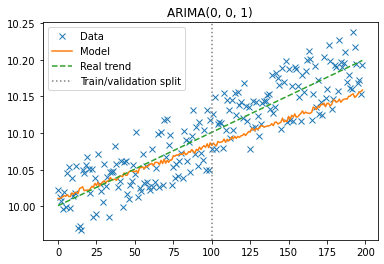

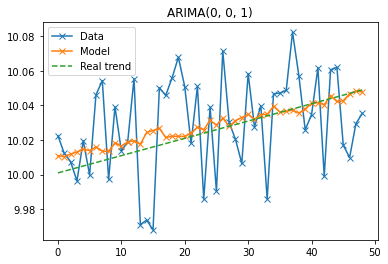

In [9]:
evaluate_arima((0, 0, 1))

Clearly, the slope obtained from fitting on the training data was off, leading to big errors in the validation data set. The RMSE obtained from the training set is optimistic. We see that even a small error in the slope will  lead to large errors on the y-axis for large times. Note that a simple linear model will suffer from the same issue. 

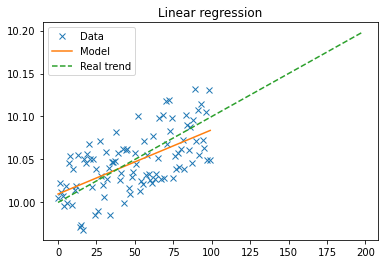

In [10]:
# Ordinary least squares, linear model: y = ax + b
times
y = trend(times)+noise(times)
X = np.column_stack((np.ones(len(times)), times))
ols_model = sm.OLS(y[:split], X[:split,:])
ols_fit = ols_model.fit()
yhat = ols_fit.predict(X[:split, :])
plt.plot(y[:split], 'x', label='Data')
plt.plot(yhat, label="Model")
plt.plot(trend(times)[:-1], '--', label='Real trend')
plt.legend()
plt.title("Linear regression");

## Difference model, ARIMA(0, 1, 0)
The issues we saw previously of finding the "perfect" slope, also accurate for long timeseries, is reduced for a simple difference/random walk model, I(1). For this model the next step is always predicted to be the current step, there is no slope, and there can be no gradual increase in errors. For being a naive model without any parameters to fit, it performs pretty well, at least better than the MA(1) model. However, when zooming in we see that there are still rather large errors due to the noise. Also, the larger the slope, the worse this model would perform.

Model coefficients:
sigma2: 0.0017727956943741645
--------------------------------------------------------------------------------
Metrics:
RMSE train = 0.04211
RMSE validation = 0.04014
--------------------------------------------------------------------------------


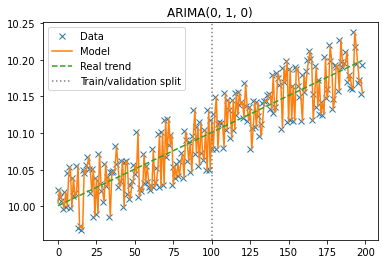

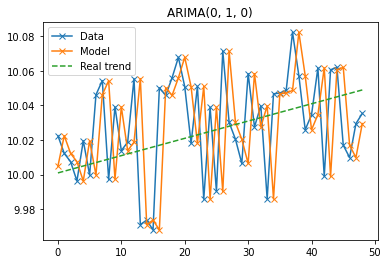

In [11]:
evaluate_arima((0, 1, 0))

## IMA model, ARIMA(0, 1, 1)
The I(1) model can be improved by adding MA term. We see that this smoothens the predictions and reduces the error significantly.

Model coefficients:
ma.L1: -0.8769372666496205
sigma2: 0.000891864761077701
--------------------------------------------------------------------------------
Metrics:
RMSE train = 0.02993
RMSE validation = 0.02989
--------------------------------------------------------------------------------


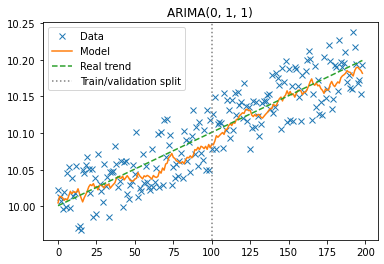

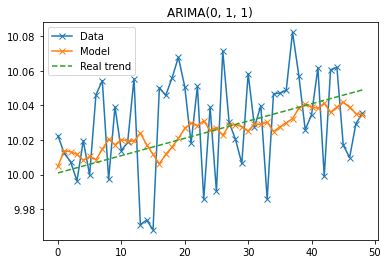

In [12]:
evaluate_arima((0, 1, 1))

## AR model, ARIMA (1, 0, 0)
Finally, we can investigate a simple AR(1) model. However, we see that this suffers from the same slope issue as the MA(1) model.

Model coefficients:
const: 10.009037963397267
x1: 0.0007473548624548165
ar.L1: -0.13792381628194067
sigma2: 0.0007708846521832891
--------------------------------------------------------------------------------
Metrics:
RMSE train = 0.02776
RMSE validation = 0.04431
--------------------------------------------------------------------------------


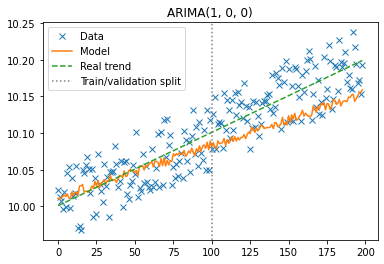

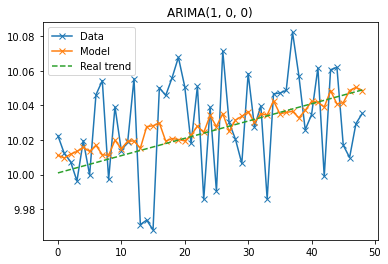

In [13]:
evaluate_arima((1, 0, 0))

Complementing it by IMA terms, we get simular results as for the ARIMA(0, 1, 1) model.

Model coefficients:
ar.L1: -0.15852023699158155
ma.L1: -0.8407961549582519
sigma2: 0.0008742844525848267
--------------------------------------------------------------------------------
Metrics:
RMSE train = 0.02963
RMSE validation = 0.02966
--------------------------------------------------------------------------------


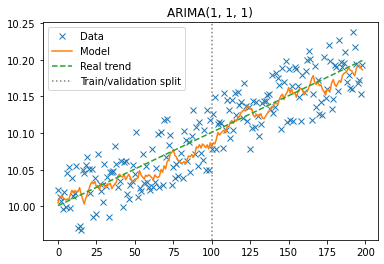

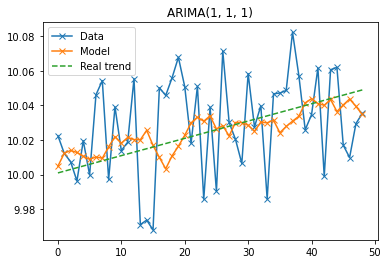

In [28]:
evaluate_arima((1, 1, 1))

## Summary
For the trend+noise dataset the ARIMA(1,1,1) with validation **RMSE=0.02966** performed the best, followed closely by ARIMA(0, 1, 1) model with RMSE=0.02989. This amounts to a modest relative difference in RMSE of about 1%. The AR(1) model performed the worst with validation RMSE=0.04431.

# Trend+noise+autocorrelation data
Here we add 1-lag autocorrelation term to the signal, so we expect a model with AR terms to  have some advantage.

## ARIMA(0, 1, 0)

Model coefficients:
sigma2: 0.00029531048401980716
--------------------------------------------------------------------------------
Metrics:
RMSE train = 0.01718
RMSE validation = 0.01878
--------------------------------------------------------------------------------


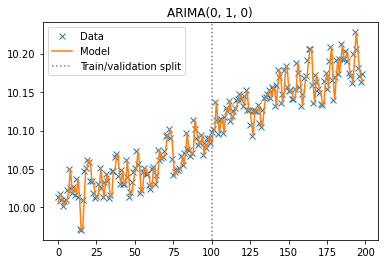

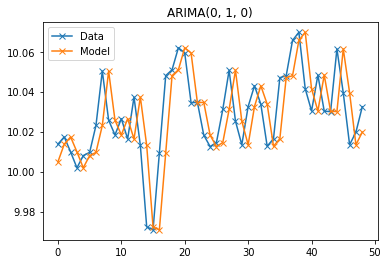

In [365]:
evaluate_arima((0, 1, 0), autocorr=True) ##

## ARIMA(0, 1, 1)

Model coefficients:
ma.L1: 0.15437167395283843
sigma2: 0.00029288396624868184
--------------------------------------------------------------------------------
Metrics:
RMSE train = 0.01712
RMSE validation = 0.01877
--------------------------------------------------------------------------------


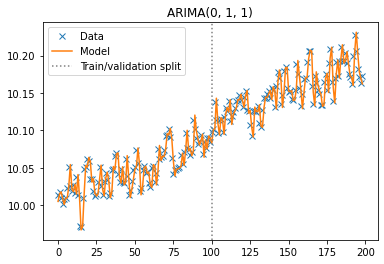

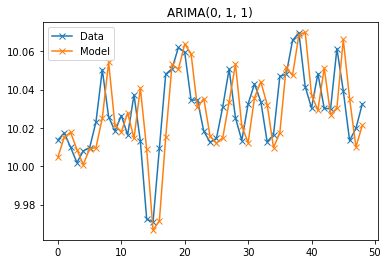

In [14]:
evaluate_arima((0, 1, 1), autocorr=True)

## ARIMA(1, 1, 1)

Model coefficients:
ar.L1: -0.6286324919455285
ma.L1: 0.9525112384510628
sigma2: 0.00025251595224636724
--------------------------------------------------------------------------------
Metrics:
RMSE train = 0.01595
RMSE validation = 0.01694
--------------------------------------------------------------------------------


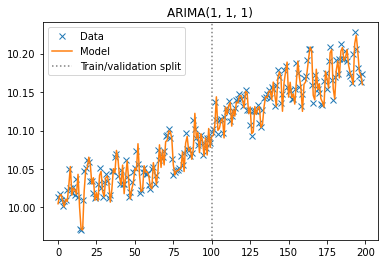

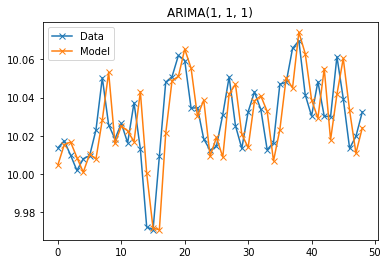

In [15]:
evaluate_arima((1, 1, 1), autocorr=True)

Indeed, now **ARIMA(1,1,1) has a ~10% lower RMSE than ARIMA(0,1,1)** (RMSE=0.01694 vs RMSE=0.01877). We can compare that to 1% difference when there was no autocorrelation in the data. Note that running `evaluate_arima` with another seed, reproduces this result.

# Tensorflow neural network model for timeseries
A fully-connected neural network can also be used for time-series predictions. Here, I use Tensorflow for this purpose.

## Prepare dataset
First, generate an artifical timeseries dataset:

In [16]:
def generate_data(autocorr=False, seasons=False, seed=0, num_times=200):
    times=np.arange(num_times)
    x = trend(times) + noise(times, seed=seed)
    if seasons:
        x += seasonal(times, pattern=linear_pattern)
    if autocorr:
        x = autocorrelation(x)
    return x

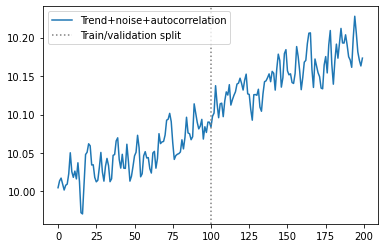

In [22]:
x = generate_data(autocorr=True)
split = 100
x_train = x[:split]
times_train= times[:split]
plt.plot(x, label='Trend+noise+autocorrelation');
plt.axvline(x=split, linestyle=':', color='gray', label='Train/validation split')
plt.legend();

The network takes as input a segments of the timeseries of a given window size, and uses that to predict the last element in the window. I.e., 
$[x_{t-w}, x_{t-w+1}, ..., x_{t-1}] \to x_t$. Tensorflow's `Dataset`  helps us to define this mapping:

In [23]:
# Based on: https://www.tensorflow.org/guide/data#time_series_windowing

def window_dataset(ds, window_size=5, shift=1, stride=1):
    """Return windowed dataset."""
    if isinstance(ds, np.ndarray):
        ds = tf.data.Dataset.from_tensor_slices(ds)
    
    # Perform windowing. Result is nested, a dataset of "windows",
    # where each window is itself a dataset.
    windows = ds.window(window_size, shift=shift, stride=stride)

    # Transform window dataset into to batch datasets (with 1 sample)
    # and flatten results (concatenate batch datasets)
    def window_to_batch(window):
        # Make sure all windows are the same size by dropping remainder, if any.
        return window.batch(window_size, drop_remainder=True)

    windows = windows.flat_map(window_to_batch)

    return windows

In [24]:
def make_dataset(x, window_size=5, shuffle_buffer_size=None, batch_size=None):
    """Form input-to-output windows."""
    
    # Make windows of given size for predicting the value after the window (+1)
    # Elements: [x_i, ..., x_{i+w}]
    ds = window_dataset(x, window_size=window_size+1)

    # Map window of window_size-1 element (input) to last element (output)
    # Elements (tuple): ([x_i, ..., x_{i+w-1}], x_{i+w})
    #return ds.map(lambda z: z[-1])
    ds = ds.map(lambda z: (z[:-1], z[-1:]))
    
    # Shuffle and batch
    if shuffle_buffer_size:
        ds = ds.shuffle(shuffle_buffer_size)
    if batch_size:
        # Allow the last batch to be smaller
        ds = ds.batch(batch_size, drop_remainder=False)
    
    return ds

These are the windowed input and the output times that are fed to the network during training:

In [25]:
# Config
window_size=5

ds_times = make_dataset(times_train, window_size=window_size)
print("Input, output:")
for t in ds_times.take(5):
    print(f"{t[0].numpy()}, {t[1].numpy()}")

Input, output:
[0 1 2 3 4], [5]
[1 2 3 4 5], [6]
[2 3 4 5 6], [7]
[3 4 5 6 7], [8]
[4 5 6 7 8], [9]


For training, the data is also shuffled and batched:

In [30]:
# Config
shuffle_buffer_size = len(times_train) # this gives perfect randomization
batch_size = 32

ds_times = make_dataset(times_train, window_size=window_size, shuffle_buffer_size=shuffle_buffer_size, batch_size=batch_size)
print("Times:")
for t in ds_times.take(5):
    # Print first sample in batch
    print(f"\nBatch shapes; input: {t[0].shape}, output: {t[1].shape}")
    print(f"First sample in batch:")
    print(f"{t[0].numpy()[0]}, {t[1].numpy()[0]}")

Times:

Batch shapes; input: (32, 5), output: (32, 1)
First sample in batch:
[13 14 15 16 17], [18]

Batch shapes; input: (32, 5), output: (32, 1)
First sample in batch:
[4 5 6 7 8], [9]

Batch shapes; input: (31, 5), output: (31, 1)
First sample in batch:
[ 8  9 10 11 12], [13]


Of course, it's the data of those time indices that is used for training.

In [31]:
ds = make_dataset(x_train, window_size=window_size, shuffle_buffer_size=shuffle_buffer_size, batch_size=batch_size)

print("Input, output:")
for t in ds.take(5):
    # Print first sample in batch
    print(f"\nBatch shapes; input: {t[0].shape}, output: {t[1].shape}")
    print(f"First sample in batch:")
    print(f"{t[0].numpy()[0]}, {t[1].numpy()[0]}")

Input, output:

Batch shapes; input: (32, 5), output: (32, 1)
First sample in batch:
[10.06725407 10.07111797 10.11385343 10.10174232 10.08988913], [10.08132835]

Batch shapes; input: (32, 5), output: (32, 1)
First sample in batch:
[10.05090936 10.07298941 10.05680075 10.01907543 10.02299987], [10.04634697]

Batch shapes; input: (31, 5), output: (31, 1)
First sample in batch:
[10.0324716  10.04624977 10.05090936 10.07298941 10.05680075], [10.01907543]


## Model definition
The model architecture is defined by a number of fully connected layers:

In [32]:
def neural_network(input_shape, output_shape, num_nodes=10, activation='relu'):
    model = tf.keras.Sequential()
    
    #  Allow more general input shape
    model.add(tf.keras.layers.Flatten(input_shape=input_shape))
    
    # Add layers with given number of nodes.
    # Nodes can be iterable or integer (single layer)
    if isinstance(num_nodes, int):
        num_nodes = [num_nodes]
    for num in num_nodes:
        model.add(tf.keras.layers.Dense(num, activation=activation))

    # Output layer (allow for more general output shape)
    num_out = 1
    for num in output_shape:
        if num:
            num_out *= num
    model.add(tf.keras.layers.Dense(num_out))
    model.add(tf.keras.layers.Reshape(output_shape))

    return model

Note that the model depends on the window size, since it needs to know the input and output shapes.

In [37]:
# Ignore batch dimension of tensorflow tensor shapes
input_shape, output_shape = (tuple((dim for dim in spec.shape if dim)) for spec in ds.element_spec)
print(f"Input shape = {input_shape}, output shape = {output_shape}")

Input shape = (5,), output shape = (1,)


In [40]:
# config
num_nodes = [10, 10]

model = neural_network(input_shape, output_shape, num_nodes=num_nodes)
model.summary()

# We could also produce a graph with the code below. It requires having graphviz installed.
# tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 5)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                60        
_________________________________________________________________
dense_7 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
_________________________________________________________________
reshape_2 (Reshape)          (None, 1)                 0         
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________


The `None` shape above refers to an arbitrary batch shape, chosen $>1$ for more efficient parallelized training. The flatten and reshape layer just takes care of flattening the input and reshaping the output for the case of a multivariate timeseries, but doesn't add any extra parameters. Each layer $i$ transforms the input vector $x$ of length $n_i$ into an output vector of length $n_{i+1}$ by a linear transformation $Wx + b$, where $W$ is a $(n_i \times n_{i+1})$-matrix and $b$ is a $n_{i+1}$-length bias vector. Each layer thus adds $n_i\times n_{i+1} + n_{i+1}$ parameters. Here,

In [849]:
print("Number of parameters:")
print(f"Layer 1: {input_shape[0]*num_nodes[0]+num_nodes[0]}")
print(f"Layer 2: {num_nodes[0]*num_nodes[1]+num_nodes[1]}")
print(f"Output layer: {num_nodes[1]*output_shape[0] + output_shape[0]}")

Number of parameters:
Layer 1: 60
Layer 2: 110
Output layer: 11


The activation function $h$, here defaulting to be a [ReLu function](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)), adds nonlinearity to the model. The total transformation of a layer, including this activation, is is $x' = h(Ax + b)$. 

## Training

In [42]:
# Config
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9),
    loss=tf.keras.losses.MeanSquaredError(),
)

In [44]:
# Train
history = model.fit(
    ds,
    epochs=1000,
    verbose=0,
)

In [211]:
def plot_rmse_history(history, tail=None):
    rmse_hist = np.sqrt(history.history['loss'])
    epochs = list(range(len(rmse_hist)))

    fig, axes = plt.subplots(2, 1, figsize=(4, 4*2))
    ax = axes[0]
    ax.plot(epochs, rmse_hist, label='train loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('RMSE')
    ax.legend()

    ax = axes[1]
    tail = tail or len(rmse_hist//5)
    s = slice(-tail, None)
    ax.plot(epochs[s], rmse_hist[s], label='train loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('RMSE')
    ax.legend()

From the training curve, we see that after a few tens of epochs, nothing much happens in terms of model performance:

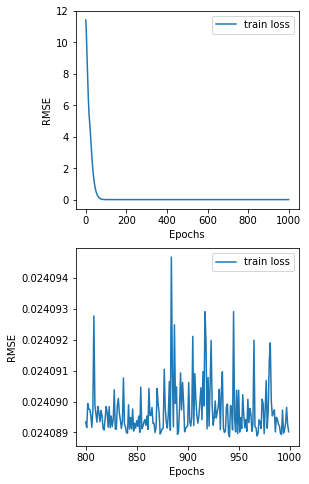

In [192]:
plot_rmse_history(history)

## Predict/evaluate
We now evaluate the trained model more quantitatively, on both the training and the validation set.

In [265]:
def evaluate_nn(times, x, model, debug=False, split=100, plot=True, verbose=True):
    """Evaluate trained tf neural network model."""
    window_size = model.input_shape[-1]

    # Make predictions for whole dataset
    # Note: need batch_size >= 1 , model expects it.
    ds = make_dataset(x, window_size=window_size, batch_size=1)
    
    # Split input ("x") and output ("y")
    # y is the target
    ds_x = ds.map(lambda x, y: x)
    
    if debug:
        print(":"*80)

        ds_y = ds.map(lambda x, y: y)
        
        print("Dataset elements (first sample):")
        first_x, first_y = next(ds_x.as_numpy_iterator()), next(ds_y.as_numpy_iterator())
        print(f"Input: {first_x}")
        print(f"Output: {first_y}")

        # Flatten the output as much as possible to be compatible with the output of `model.predict`
        ds_y = ds_y.unbatch()
        try:
            # if batch_size
            ds_y = ds_y.unbatch()
        except:
            pass

        #y = list(ds_y.as_numpy_iterator())
        y = np.fromiter(ds_y.as_numpy_iterator(), dtype=ds_y.element_spec.dtype.as_numpy_dtype)  

        assert np.isclose(y, x[window_size:]).all()
        print(":"*80)


    # Pad non-predicted times with zeros
    xhat = np.zeros(times.shape)
    xhat[window_size:] = model.predict(ds_x).ravel()
    
    # Metrics
    start = window_size
    rmse_train = rmse(xhat[start:split], x[start:split])
    rmse_valid = rmse(xhat[split:], x[split:])

    if verbose:
        print("Metrics:")
        print(f"RMSE train = {rmse_train:.5f}")
        print(f"RMSE validation = {rmse_valid:.5f}")
        print("-"*80)
    
    if plot:
       # Plot all times
        plt.figure()
        s = slice(start, None)
        #plt.grid(True)
        plt.plot(times[s], x[s], 'x', label='Data')
        plt.plot(times[s], xhat[s], '-', label=f'Model')
        plt.axvline(x=split, linestyle=':', color='gray', label='Train/validation split')
        plt.legend()
        plt.title(f"Neural network (window_size={window_size})");

        # PLot first times
        plt.figure()
        #plt.grid(True)
        s = slice(start, 50)
        plt.plot(times[s], x[s], 'x-', label='Data')
        plt.plot(times[s], xhat[s], 'x-', label=f'Model')
        plt.legend()
        plt.title(f"Neural network (window_size={window_size})");

    return rmse_train, rmse_valid
            

Metrics:
RMSE train = 0.02409
RMSE validation = 0.02385
--------------------------------------------------------------------------------


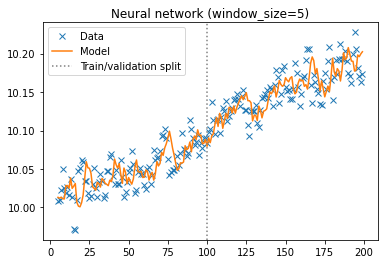

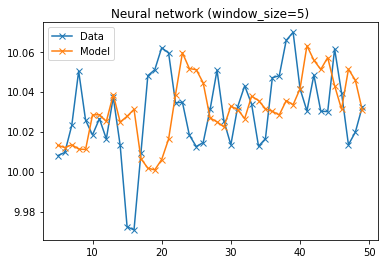

In [194]:
evaluate_nn(times, x, model, debug=False)

We can note that the ARIMA(1,1,1) model here performed better (RMSE=0.01694) than this simple neural network approach.

#  Hyperparameter tuning

## Window size
We can now package the training and evaluation performed above into one function and do some lightweight hyperparameter tuning/exploration. To begin, I try decreasing the window size.

In [667]:
def train_and_evaluate(times, x, split=100,
                       window_size=5, num_nodes=(10, 10), optimizer=None, epochs=1000,
                       plot=True, quiet=False):
    """Train and evaluate neural network model and return (model, history)."""
    # Config
    # -------
    # Model architecture:
    # - window_size, num_nodes
    
    # Training
    shuffle_buffer_size = split # this gives perfect randomization
    batch_size = 32
    optimizer = optimizer or tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
    loss = tf.keras.losses.MeanSquaredError()
    # -------

    ds = make_dataset(x_train, window_size=window_size, shuffle_buffer_size=shuffle_buffer_size, batch_size=batch_size)

    input_shape, output_shape = (tuple((dim for dim in spec.shape if dim)) for spec in ds.element_spec)
    model = neural_network(input_shape, output_shape, num_nodes=num_nodes)
    
    model.compile(
        optimizer=optimizer,
        loss=loss
    )
    history = model.fit(
        ds,
        epochs=epochs,
        verbose=0,
    )
    
    if plot:
        plot_rmse_history(history)
    
    metrics = evaluate_nn(times, x, model, debug=False, plot=plot, verbose=not quiet)
    
    return model, metrics

Metrics:
RMSE train = 0.01705
RMSE validation = 0.01865
--------------------------------------------------------------------------------


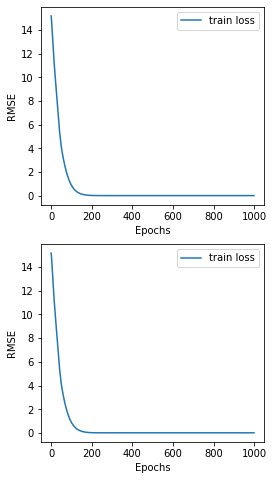

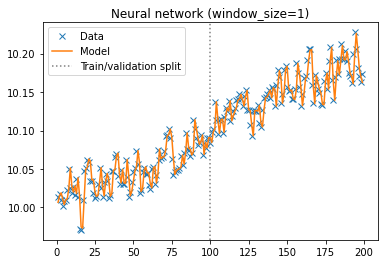

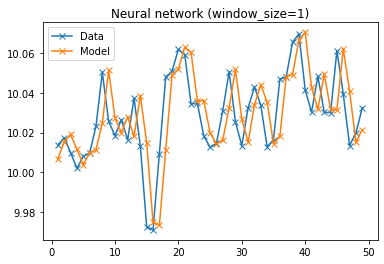

In [285]:
model, (rmse_train, rmse_valid) = train_and_evaluate(times, x, window_size=1, epochs=1000)

Clearly, it's possible to get lower validation RMSE, but it's unclear whether this is actually due to random effects (e.g. due to the optimizer). To get a better idea I collect some more statistics.

In [288]:
window_sizes = (1, 2, 4, 8, 16, 32)
num_samples = 10
epochs=500

In [289]:
rmses = defaultdict(list)
for w_size in window_sizes:
    print(f"Evaluating window size {w_size}:")
    for i in range(num_samples):        
        print(i, end='\t')
        model, (rmse_train, rmse_valid) = train_and_evaluate(times, x, window_size=w_size, epochs=epochs,
                                                plot=False, quiet=True)
        rmses[w_size].append(rmse_valid)
    print()

Evaluating window size 1:
0	1	2	3	4	5	6	7	8	9	
Evaluating window size 2:
0	1	2	3	4	5	6	7	8	9	
Evaluating window size 4:
0	1	2	3	4	5	6	7	8	9	
Evaluating window size 8:
0	1	2	3	4	5	6	7	8	9	
Evaluating window size 16:
0	1	2	3	4	5	6	7	8	9	
Evaluating window size 32:
0	1	2	3	4	5	6	7	8	9	


Turns out it's hard to converge the optimization sometimes, 500 epochs not always enough. Assuming this is not related to the window size, remove such outliers to be able to visualize the results.

In [330]:
tol = 1
rmses_outliers = {k: [v for v in l if v > tol] for k, l in rmses.items()}
rmses = {k: [v for v in l if v <= tol] for k, l in rmses.items()}
print("Removed outliers:", rmses_outliers)

Removed outliers: {1: [9.759332866885615], 2: [], 4: [9.856378745817084], 8: [], 16: [], 32: []}


In [331]:
mean_rmses = {k: np.mean(v) for k, v in rmses.items()}
stdev_rmses = {k: np.std(v) for k, v in rmses.items()}

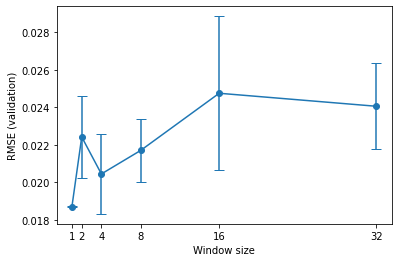

In [357]:
fig, ax = plt.subplots(1)
ax.errorbar(x=list(rmses.keys()), y=list(mean_rmses.values()), xerr=None, yerr=list(stdev_rmses.values()), fmt='o-', capsize=5)
ax.set_xticks(list(rmses.keys()));
ax.set_ylabel('RMSE (validation)')
ax.set_xlabel('Window size');

This was a relatively small hyperparameter search, but still it's clear that having `window_size=1` yields the best result with comparatively _very_ small standard deviation. This choice of window size results in a somewhat trivial forecasting model, essentially amounting to predicting $x_{t+1}$ from $x_t$, as we can see by looking at one of the result plots:

Metrics:
RMSE train = 0.01708
RMSE validation = 0.01874
--------------------------------------------------------------------------------


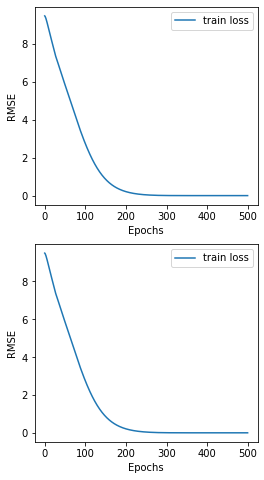

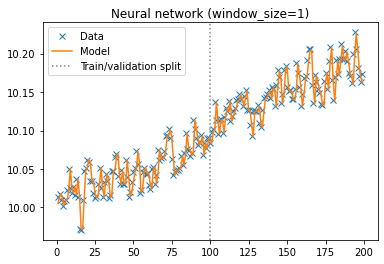

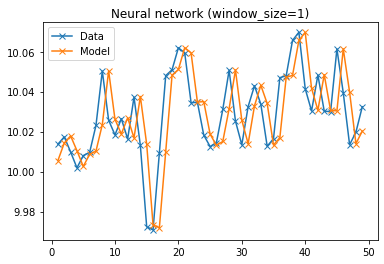

In [367]:
 model, (rmse_train, rmse_valid) = train_and_evaluate(times, x, window_size=1, epochs=epochs,
                                                plot=True, quiet=False)

However, because the parameters of the model were found by fitting, $x_{t+1}$ is only approximately equal to ${x_t}$. We can also note that this is amounts to something similar to the basic ARIMA(0, 1, 0) model, which had validation RMSE=0.01878 for the same data. Quite possibly, the artificial data used here does not have the complexity to warrant using a neural network since even naive predictions work fairly well.

## Learning rate
When tuning the window size, we saw that in certain cases, by chance, the model doesn't converge for 500 epochs. Perhaps the learning rate of the optimizer can be selected better?
 
 
I try using a simple approach of gradually increasing starting with a small learning rate and then deterministically increasing the learning rate at each epoch of fitting the model. The very small learning rates (early epochs) and the very large learning rates should get large loss values and we want to find a sweet spot in between.

To do this within the tf fitting function, I use a callback.

In [479]:
def learning_rate_at_epoch(epoch):
    return 1e-8 * 10**(epoch/20)

epochs = 140

learning_rates = [learning_rate_at_epoch(i) for i in range(epochs)]
print(f"Starting learning rate: {learning_rates[0]}")
print(f"Final learning rate: {learning_rates[-1]}")

Starting learning rate: 1e-08
Final learning rate: 0.08912509381337458


In [480]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(learning_rate_at_epoch)
optimizer = tf.keras.optimizers.SGD(lr=learning_rates[0], momentum=0.9)
model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanSquaredError())
ds = make_dataset(x[:100], window_size=1, shuffle_buffer_size=len(x[:100]), batch_size=32)

In [481]:
history = model.fit(ds, epochs=epochs, callbacks=[lr_schedule], verbose=0)

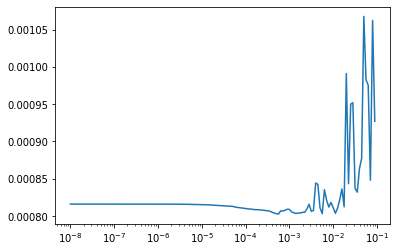

In [483]:
plt.semilogx(history.history['lr'], history.history['loss'], '-')

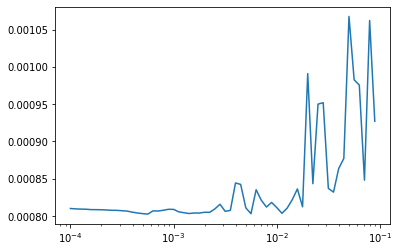

In [534]:
# Just zoomed in
s=slice(80,None)
plt.semilogx(history.history['lr'][s], history.history['loss'][s], '-')

Based on this, I'd pick a learning rate in between 1e-4 and 1e-3, say 3e-4. We can do a test to see if it helps.

In [604]:
def sample_rmses(times, x, optimizer=None, num_samples=50, epochs=200):
    rmses = []
    for i in range(num_samples):        
        print(i, end='\t')
        model, (rmse_train, rmse_valid) = train_and_evaluate(times, x, window_size=1,
                                                             epochs=epochs, optimizer=optimizer,
                                                             plot=False, quiet=True)
        rmses.append(rmse_valid)
        if (i>0) and (i%10)==0:
            print()
    return rmses

In [605]:
rmses = sample_rmses(times, x)

0	1	2	3	4	5	6	7	8	9	10	
11	12	13	14	15	16	17	18	19	20	
21	22	23	24	25	26	27	28	29	30	
31	32	33	34	35	36	37	38	39	40	
41	42	43	44	45	46	47	48	49	

In [606]:
rmses_opt = sample_rmses(times, x, optimizer=tf.keras.optimizers.SGD(lr=3e-4, momentum=0.9))

0	1	2	3	4	5	6	7	8	9	10	
11	12	13	14	15	16	17	18	19	20	
21	22	23	24	25	26	27	28	29	30	
31	32	33	34	35	36	37	38	39	40	
41	42	43	44	45	46	47	48	49	

In [607]:
print("RMSEs:")
print(f"Default, learning rate = 1e-6: {np.mean(rmses)} +/- {np.std(rmses)}")
print(f"Optimized, learning rate = 3e-4: {np.mean(rmses_opt)} +/- {np.std(rmses_opt)}")

RMSEs:
Default, learning rate = 1e-6: 1.284475991029669 +/- 2.503124302050658
Optimized, learning rate = 3e-4: 0.02142722978456146 +/- 0.0012861731212284757


We see that there is a huge difference! We can also verify this by checking the number of "outliers" (RMSE values above a certain tolerance) and see that the fraction of outliers decreases to zero when the learning rate was optimized:

In [614]:
frac = len([v for v in rmses if v > tol])/len(rmses)
frac_opt = len([v for v in rmses_opt if v > tol])/len(rmses_opt)
print(f"Outlier fraction default: {frac}; optimized: {frac_opt}")

Outlier fraction default: 0.3; optimized: 0.0


## Window size (seasonal data)
I'm curious whether a window size > 1 becomes advantageous if we add some more complexity to the artificial data set, so I add some seasonality (with a periodicity of 25 timesteps). I then scan different window sizes, as I did previously:

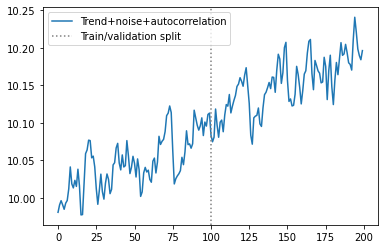

In [619]:
x = generate_data(autocorr=True, seasons=True)
split = 100
plt.plot(x, label='Trend+noise+autocorrelation');
plt.axvline(x=split, linestyle=':', color='gray', label='Train/validation split')
plt.legend();

In [620]:
window_sizes = (1, 2, 4, 8, 16, 32)
num_samples = 20
epochs=200
optimizer=tf.keras.optimizers.SGD(lr=3e-4, momentum=0.9)

In [622]:
rmses = defaultdict(list)
for w_size in window_sizes:
    print(f"Evaluating window size {w_size}:")
    for i in range(num_samples):        
        print(i, end='\t')
        model, (rmse_train, rmse_valid) = train_and_evaluate(times, x, window_size=w_size,
                                                             epochs=epochs, optimizer=optimizer,
                                                             plot=False, quiet=True)
        rmses[w_size].append(rmse_valid)
    print()

Evaluating window size 1:
0	1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16	17	18	19	
Evaluating window size 2:
0	1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16	17	18	19	
Evaluating window size 4:
0	1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16	17	18	19	
Evaluating window size 8:
0	1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16	17	18	19	
Evaluating window size 16:
0	1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16	17	18	19	
Evaluating window size 32:
0	1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16	17	18	19	


In [624]:
tol = 1
rmses_outliers = {k: [v for v in l if v > tol] for k, l in rmses.items()}
rmses = {k: [v for v in l if v <= tol] for k, l in rmses.items()}
print("Removed outliers:", rmses_outliers)

Removed outliers: {1: [], 2: [], 4: [], 8: [], 16: [], 32: []}


In [625]:
mean_rmses = {k: np.mean(v) for k, v in rmses.items()}
stdev_rmses = {k: np.std(v) for k, v in rmses.items()}

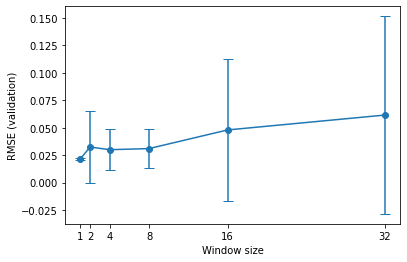

In [627]:
fig, ax = plt.subplots(1)
ax.errorbar(x=list(rmses.keys()), y=list(mean_rmses.values()), xerr=None, yerr=list(stdev_rmses.values()), fmt='o-', capsize=5)
ax.set_xticks(list(rmses.keys()));
ax.set_ylabel('RMSE (validation)')
ax.set_xlabel('Window size');

For this dataset it's still `window_size`=1 that's the winnner in terms of both mean and standard deviation. Nonetheless, the error bars of larger window sizes still leaves the door open for the larger window sizes providing some advantages with more tuning and analysis work. However, the takeaway here is that **one should always start with a robust and simple model** as a first baseline, because training more complex models requires extra work and will not necessarily pay off.